# Notebook d'entraînement des algorithmes avec photos nettoyées
## Adrian Rodriguez
## Projet 7 parcours Ingénieur Machine Learning
[Accès projet git](https://github.com/Adrian1903/Developpez-une-preuve-de-concept)

[Plus d'informations](https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning)

---
# 0. Contexte
Un rapport sur les erreurs de classification des races de chiens a été soumis à l’association de protection des animaux. Dans ce rapport, il est recommandé d’implémenter une solution de détection d’objet pour améliorer la qualité des photos. Cette solution doit isoler l’objet à classifier en procédant à un rognage.
Cette nouvelle méthode fera appel au dernier YOLO, version 4.

## Sources bibliographiques :
* [Papier sur YOLOv4](https://arxiv.org/pdf/2004.10934v1.pdf)
* [Article sur Medium](https://medium.com/@alexeyab84/yolov4-the-most-accurate-real-time-neural-network-on-ms-coco-dataset-73adfd3602fe)
* [Code source](https://github.com/AlexeyAB/darknet)
* [Tutoriel](https://colab.research.google.com/drive/12QusaaRj_lUwCGDvQNfICpa7kA7_a2dE)

## Prototype
* Dataset : [Stanford Dogs Dataset](https://www.kaggle.com/jessicali9530/stanford-dogs-dataset)
* Méthode baseline : [Modèle Xception 2017 (en production)](https://github.com/Adrian1903/Classez-des-images-l-aide-d-algorithmes-de-Deep-Learning/blob/master/dev/04_cnn_transfer_learning.ipynb) 
* Méthode mise en oeuvre :
  * Phase 1 : Intégration et mesure du détecteur d’objet en production
  * Phase 2 : Si résultat de la phase 1 insuffisant, apprentissage du modèle existant avec photos recadrées et mesure des résultats




In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")
import seaborn as sns
import six

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications import InceptionV3
from keras.applications import Xception

In [2]:
# Création des fonctions
def get_dataframe(path):
    dogs_lst = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            dogs_lst.append(os.path.join(dirname, filename))

    # Je stocke dans un dataframe
    dogs_raw = pd.DataFrame(dogs_lst, columns=['uri'])

    # J'extrais la race
    dogs_raw['breeds'] = dogs_raw.uri.str.split('/').str.get(4)
    
    return dogs_raw


def split_and_generate_dataframe(df, px):
    seed = 42

    # Séparation des données d'entrainements et de tests
    train, test = train_test_split(df, test_size=0.2, random_state=seed)
    # Séparation des données d'entrainements et de validation
    train, val = train_test_split(train, test_size=0.2, random_state=seed)

    ### Paramétrage
    x = 'uri'
    y = 'breeds'

    train_batch_size = get_batch_size(len(train))
    val_batch_size = get_batch_size(len(val))
    test_batch_size = get_batch_size(len(test))

    train_datagen = ImageDataGenerator(rescale=1./255)
    train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Sans augmentation des données
    train_gen = train_datagen.flow_from_dataframe(
                      train,
                      x_col='uri',
                      y_col='breeds',
                      target_size=(px, px),
                      batch_size=train_batch_size,
                      seed=seed
                      )


    # Avec augmentation des données
    train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                              train,
                              x_col='uri',
                              y_col='breeds',
                              target_size=(px, px),
                              batch_size=train_batch_size,
                              seed=seed
                              )

    val_gen = val_test_datagen.flow_from_dataframe(
                      val,
                      x_col = x,
                      y_col = y,
                      target_size=(px, px),
                      batch_size=val_batch_size,
                      seed=seed
                      )

    test_gen = val_test_datagen.flow_from_dataframe(
                      test,
                      x_col = x,
                      y_col = y,
                      target_size=(px, px),
                      batch_size=test_batch_size,
                      seed=seed,
                      shuffle=False
                      )

    return [train_gen, train_gen_data_aug, val_gen, test_gen]

def get_batch_size(gen):
    lst = []
    dict = {}
    
    # Test des nombres entiers et intégration dans un dictionnaire
    for i in range(1,40):
        dict[i] = gen % i
    
    # Récupération du plus grand nombre entiers
    for key, value in dict.items():
        if value == 0:
            lst.append(key)

    return max(lst)


def get_model():
    model = Sequential()
    model.add(conv_base)
    model.add(GlobalAveragePooling2D())
    # model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(len(train_gen.class_indices), activation='softmax'))
    return model


def train_model(train):
    model_train = get_model()
    model_train.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    history_train = model_train.fit(train,
                                validation_data=val_gen,
                                epochs=epochs,
                                verbose=verbose,
                                callbacks=[early_stopping_monitor, model_save])
    
    plot_result_fitting(history_train, name, title, n_breeds)
    plot_confusion_matrix(model_train, name, title, n_breeds)
    
    return model_train.evaluate(test_gen)[1]


def plot_result_fitting(history, model, title, n_breeds):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax[0].set_title('Accuracy | ' + model + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'val_loss')
    ax[1].set_title('Loss function | ' + model + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_' + model + '_' + title + '_' + str(n_breeds) + '_breeds_results.png',
                transparent=True)
    plt.show()
    return None


def export_png_table(data, col_width=2.2, row_height=0.625, font_size=10,
                     header_color='#7451eb', row_colors=['#f1f1f2', 'w'],
                     edge_color='w', bbox=[0, 0, 1, 1], header_columns=1,
                     ax=None, filename='table.png', **kwargs):
    ax = None
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])
                ) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox,
                         colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    fig.savefig(filename, transparent=True)

    return None

def plot_confusion_matrix(model, name, title, n_breeds):
    pred = model.predict_classes(test_gen)
    cf_matrix = confusion_matrix(test_gen.classes, pred)
    sns.heatmap(cf_matrix, cmap='Purples')
    plt.title('Matrice de confusion  | ' + name + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    plt.axis('off')
    plt.savefig('./cnn_transfer_learning_' + name + '_' + title + '_' + str(n_breeds) + '_breeds_confusion_matrix.png',
                transparent=True)
    plt.show()
    return

---
# 1. Entraînement des modèles avec photos rognées | Charge 100% (120 races)

Nous avons 120 races sélectionnées
Evaluation de InceptionV3 en cours...
Found 13170 validated image filenames belonging to 120 classes.
Found 13170 validated image filenames belonging to 120 classes.
Found 3293 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.
87916544/87910968 [==============================] - 2s 0us/step
Epoch 1/40
439/439 [==============================] - 364s 830ms/step - loss: 1.5210 - accuracy: 0.6453 - val_loss: 0.4890 - val_accuracy: 0.8643
Epoch 2/40
439/439 [==============================] - 324s 738ms/step - loss: 0.8454 - accuracy: 0.7638 - val_loss: 0.4372 - val_accuracy: 0.8685
Epoch 3/40
439/439 [==============================] - 340s 775ms/step - loss: 0.7763 - accuracy: 0.7809 - val_loss: 0.4350 - val_accuracy: 0.8643
Epoch 4/40
439/439 [==============================] - 330s 751ms/step - loss: 0.7395 - accuracy: 0.7909 - val_loss: 0.4356 - val_accuracy: 0.8725
Epoch 5/40
439/439 [====

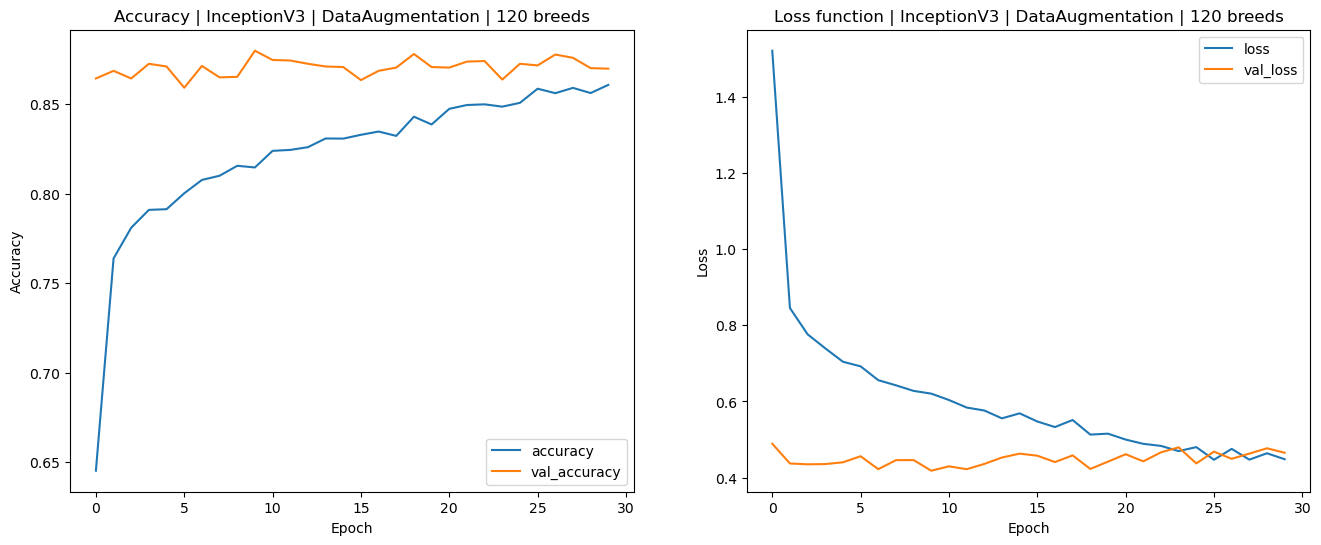

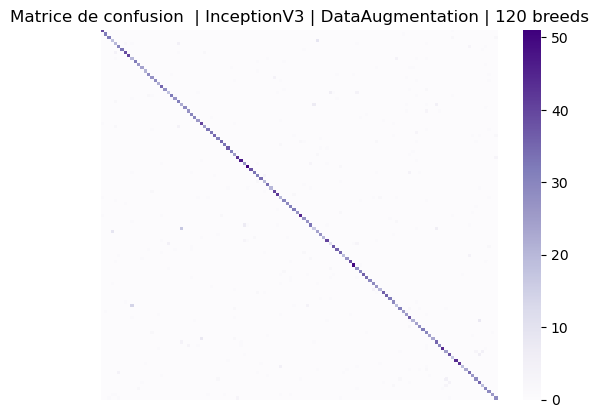

147/147 [==============================] - 19s 127ms/step - loss: 0.4122 - accuracy: 0.8763
Evaluation de Xception en cours...
Found 13170 validated image filenames belonging to 120 classes.
Found 13170 validated image filenames belonging to 120 classes.
Found 3293 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.
83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/40
439/439 [==============================] - 383s 872ms/step - loss: 1.2473 - accuracy: 0.7052 - val_loss: 0.4224 - val_accuracy: 0.8797
Epoch 2/40
439/439 [==============================] - 378s 862ms/step - loss: 0.6930 - accuracy: 0.8024 - val_loss: 0.3900 - val_accuracy: 0.8767
Epoch 3/40
439/439 [==============================] - 386s 880ms/step - loss: 0.6397 - accuracy: 0.8128 - val_loss: 0.3911 - val_accuracy: 0.8834
Epoch 4/40
439/439 [==============================] - 389s 885ms/step - loss: 0.5949 - accuracy: 0.8236 - val_loss: 

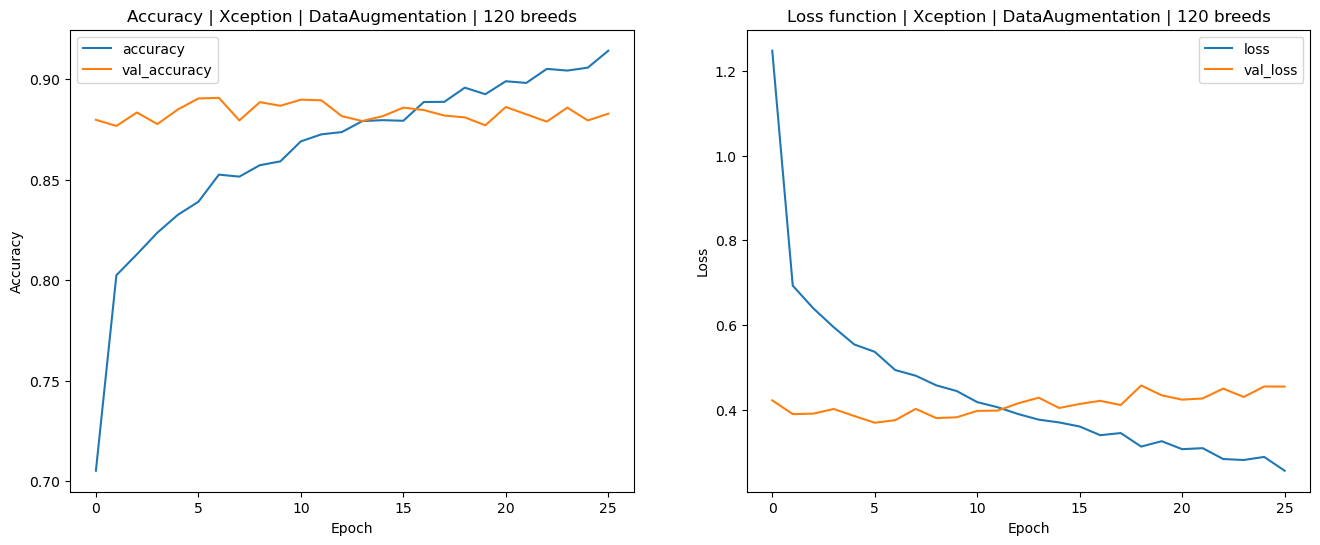

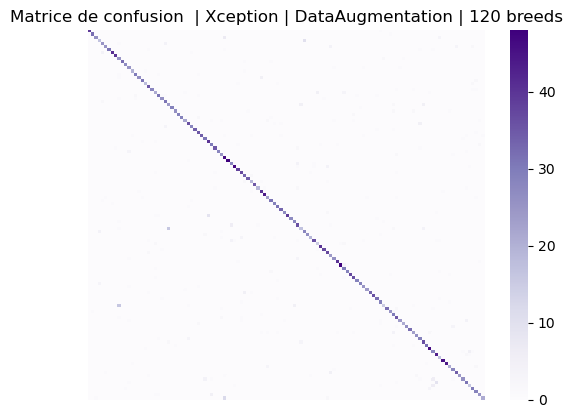

147/147 [==============================] - 23s 159ms/step - loss: 0.4084 - accuracy: 0.8807


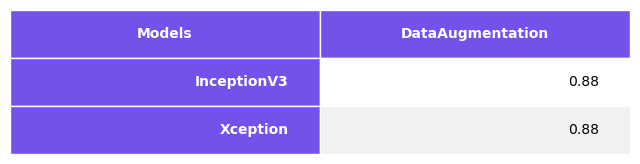

In [3]:
# Paramètrage des modèles (Nom du modèle, Modèle, Taille de l'image en entrée)
models = [('InceptionV3', InceptionV3, 299),
          ('Xception', Xception, 299)]


# Paramètrage des données d'entrées
n_breeds = 120
dogs = get_dataframe('../input/cropped-stanford-dogs-dataset/img_crop')
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées")

# Paramètrage de l'entraînement
epochs = 40
verbose = 1
early_stopping_monitor = EarlyStopping(patience=20, verbose=1, restore_best_weights=True)

# Initialisation des variables résultantes
test_accuracy = {}
results = pd.DataFrame()

for name, model, px in models:
    print(f"Evaluation de {name} en cours...")
    # Création des générateurs
    train_gen, train_gen_data_aug, val_gen, test_gen = split_and_generate_dataframe(dogs, px)
   
    # Chargement et gel de la base convolutionnelle
    conv_base = model(weights='imagenet', include_top=False, input_shape=(px, px, 3))
    conv_base.trainable = False

    
    # Entraînement du modèle avec data augmentation
    title = "DataAugmentation"
    model_save = ModelCheckpoint('best_model_' + name + '_' + title + '_' + str(n_breeds) + '_breeds.hdf5', save_best_only=True)
    
    test_accuracy[title] = train_model(train_gen_data_aug)
    
    row = pd.Series(test_accuracy, name=name)
    results = results.append(row)

results = results.reset_index().rename(columns={'index': 'Models'})
export_png_table(round(results, 2), col_width=4, filename='./cnn_transfer_learning_results_' + str(n_breeds) + '_breeds.png')